# Magnitude en fonction du temps d'injection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special
from scipy import integrate
import pandas as pd
from IPython.display import clear_output

In [2]:
def noyau(freq,H) :
    pos = freq==0 #on localise la position des zéros
    freq[pos] = 1 #On remplace les zéros par des non-zéros (1 par exemple)
    c = np.abs(freq)
    freq = c/np.tanh(2*H*c) #on applique l'opération (sans rencontrer de zéros donc)
    freq[pos] = 0 #on met des zéros aux positions des zéros du tableau de départ
    return freq

def Psi(f, deltaX, H) :
    F=np.fft.fft(f)
    freq=np.fft.fftfreq(len(f),deltaX)*2*np.pi
    K = noyau(freq, H)
    F=K*F
    psi=np.fft.ifft(F)
    return psi.real*Lb

def F(y):
    phi = y[0]
    nu = y[1]
    v = np.exp(phi)
    vm = np.mean(v)
    theta = np.exp(nu)
    PSI = Psi(v, deltaX, H)
    den = v - 1/theta - 1/2*PSI - gamma*(vm-np.ones(I+1))
    phid1 = den/(alpha1 + beta*v)
    phid2 = den/(alpha2 + beta*v)
    phidot = np.concatenate((phid1[0:K1], phid2[K1:K2+1], phid1[K2+1:]))
    nudot = 1/theta - v
    return np.array([phidot, nudot])

def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        if erreur < tol:
            return ykk, s*h
        if s*h < dtmin:
            return ykk, h
        h = s*h
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

def p(q, D, x, t):
    xi = np.abs(Lb*x/(2*np.sqrt(D*t*dc/v0)))
    return 2*q*np.sqrt(D*t*dc/v0)*(xi*(scipy.special.erf(xi)-1) + np.exp(-xi**2)/np.sqrt(np.pi))

def magnitude(U, x):
    U = np.array(U)*mu*v0

    pos = U > vseuil*mu*deltaX*v0 #on note la postion des secteurs inférieurs au seuil
    
    M0 = scipy.integrate.trapz(U[pos], temps[pos])
    Mw = 2/3*np.log(M0)-6
    return Mw

In [3]:
##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400
D = 1e-6
Q = 9530
dates = np.arange(0, 40, 0.5)

a1 = 2e-3
a2 = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

deltaX = int(Lb/4)
N = 8000
I = 2**8
L = I * deltaX
H = 2*L
h = 1e-2

d = L//20
K1 = (L//2-d)//deltaX
K2 = (L//2+d)//deltaX

alpha1 = a1/b 
alpha2 = a2/b

vseuil = 1e-2

#Conditions initiales
x = np.arange(-L//2, L//2 + 1, deltaX)
xbar = x/Lb

CI_phi = pd.read_csv('CI_phi.csv')['0'].to_numpy()
CI_nu = pd.read_csv('CI_nu.csv')['0'].to_numpy()

M = np.array([])
U = [0]

#Calcul de la référence
q = 0
temps = np.array([1e-2])

yk = np.array([CI_phi, CI_nu])

for n in range(N):
    t = temps[n]
    tbar = t*dc/v0
    pression = p(q,D,xbar,tbar)
    sigmaeff = sigma*np.ones(len(x)) - pression
    beta = eta*v0/(b*sigmaeff)
    gamma = mu*dc/(b*sigmaeff*H)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [t+h]))
    u = scipy.integrate.trapz(np.exp(yk[0]), x)
    U.append(u)
Mref = magnitude(U, x)
print('ref OK !')
U = [0]

#Calcul avec paramétrage
for top in dates :
    q = 0
    temps = np.array([1e-2])
    
    yk = np.array([CI_phi, CI_nu])
    
    for n in range(N):
        t = temps[n]
        if t >= top :
            q = Q
        tbar = t*dc/v0
        pression = p(q,D,xbar,np.max((1e-2,tbar-top*dc/v0)))
        sigmaeff = sigma*np.ones(len(x)) - pression
        beta = eta*v0/(b*sigmaeff)
        gamma = mu*dc/(b*sigmaeff*H)
        res = RKF(F, yk, h)
        yk = res[0]
        h = res[1]
        temps = np.concatenate((temps, [t+h]))
        u = scipy.integrate.trapz(np.exp(yk[0]), x)
        U.append(u)
        
    M = np.concatenate((M, [magnitude(U, x)]))
    m = 50*len(M)//len(dates)
    clear_output(wait=True)
    print('[' + int(m)*'◼️' + (50-m)*'◻️' + ']')
    U = [0]

[◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️◼️]


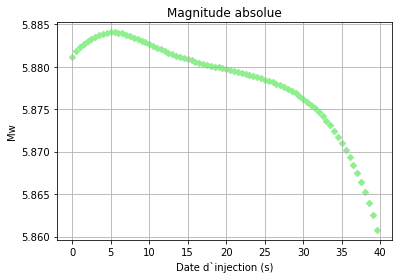

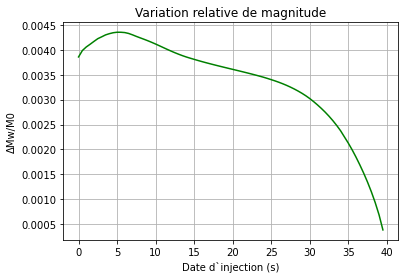

In [4]:
Mr = (M - Mref*np.ones(len(M)))/Mref

plt.scatter(dates, M, s = 20., marker = 'D', c ='lightgreen')
plt.title('Magnitude absolue')
plt.xlabel('Date d`injection (s)')
plt.ylabel('Mw')
plt.grid()
plt.show()

plt.plot(dates, Mr, c = 'green')
plt.title('Variation relative de magnitude')
plt.xlabel('Date d`injection (s)')
plt.ylabel('ΔMw/M0')
plt.grid()
plt.show()